In [1]:
import tensorflow
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV

from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.preprocessing import MinMaxScaler
from sklearn.cluster import KMeans
import numpy as np
import pandas as pd

In [2]:
# load datasets
columns_to_slice = ["subj_idx", "AV", "rt", "power", "trial_no", "noise", "response"]
df1 = pd.read_csv ('/Users/sounakmohanta/Downloads/ERSP/RT_Data/23_subs_psychophysics_USE_THIS.csv')

df2 = pd.read_csv ('/Users/sounakmohanta/Downloads/ERSP/RT_Data/15subs_ketamine_Pre_RT.csv')
df3 = pd.read_csv ('/Users/sounakmohanta/Downloads/ERSP/RT_Data/14subs_DEX_PRE_RT.csv')
df_dex = pd.read_csv ('/Users/sounakmohanta/Downloads/ERSP/RT_Data/13subs_DEX_During1_RT2.csv')
df_keta = pd.read_csv ('/Users/sounakmohanta/Downloads/ERSP/RT_Data/15subs_ketamine_During2_RT.csv')


df1 = df1[columns_to_slice]
df2 = df2[columns_to_slice]
df3 = df3[columns_to_slice]
df_dex = df_dex[columns_to_slice]
df_keta = df_keta[columns_to_slice]

df_dex["anes"] = 1
df_dex["drug"] = 1
df_dex.subj_idx = df_dex.subj_idx + 6000

df_keta["anes"] = 2
df_keta["drug"] = 2
df_keta.subj_idx = df_keta.subj_idx + 16000


##df = df1


df2.subj_idx = df2.subj_idx + 500
df1["drug"] = 0
df2["drug"] = 2
df3["drug"] = 1
df_pre = pd.concat([df1, df2, df3], ignore_index = True)
df_pre["anes"] = 0

#df.anes
#df_keta["anes"] = 1
df2["anes"] = 0
df1["anes"] = 0
df3["anes"] = 0
#df1= df1[df1["trial_no"]>50]
#df2= df2[df2["trial_no"]>50]
#df_pre_keta = pd.concat([df2, df_keta], ignore_index = True)
#df_pre_dex = pd.concat([df1, df_dex], ignore_index = True)

#df = df_pre
#df["anes"] = 0
#df = pd.concat([df_pre, df_dex], ignore_index = True)

In [2154]:
df

,subj_idx,AV,rt,power,trial_no,noise,response,drug,anes
0,8,13,561.1,-0.007752,1,1,0,0,0
1,8,11,507.6,-0.022572,2,1,1,0,0
2,8,31,566.5,0.008333,3,1,1,0,0
3,8,32,914.0,-0.007407,4,1,1,0,0
4,8,33,720.5,-0.022222,5,1,0,0,0
...,...,...,...,...,...,...,...,...,...
26406,16034,21,1026.0,0.252840,186,1,1,2,2
26407,16034,33,694.2,0.083248,187,0,1,2,2
26408,16034,33,771.8,0.087831,188,0,1,2,2
26409,16034,32,1027.3,0.092369,189,1,1,2,2


In [3]:
# NORM FUNC
def norm_dataset(df):
    #select only matching trials
    df['match'] = np.where((df['AV'] == 11) | (df['AV'] == 22) | (df['AV'] == 33), 1, 0)

    #select only match trials
    df_match = df[(df["match"] == 1)]
    df_match.loc[df['AV'] == 11, 'A'] = 0
    df_match.loc[df['AV'] == 22, 'A'] = 1
    df_match.loc[df['AV'] == 33, 'A'] = 2

    df_match = df_match[(df_match["response"] == 1)]
    #divide noise vs clear data
    df_clear_m= df_match[(df_match["noise"] == 0)]
    df_noisy_m= df_match[(df_match["noise"] == 1)]

    # convert A to integer
    df_clear_m["A"] =  df_clear_m["A"].astype('int64')
    # convert A to integer
    df_noisy_m["A"] =  df_noisy_m["A"].astype('int64')


    df_match["A"] =  df_match["A"].astype('int64')

    df_clear_m = df_clear_m[["subj_idx", "A", "rt", "power", "trial_no", "noise", "anes", "drug"]]
    df_noisy_m = df_noisy_m[["subj_idx","A", "rt", "power", "trial_no", "noise", "anes", "drug"]]
    df_match = df_match[["subj_idx","A", "rt", "power", "trial_no", "noise", "anes", "drug"]]

    df_match["normN_trial_no"] = df_match.groupby("subj_idx")['trial_no'].transform(lambda x: (x/ np.max(x)))
    df_match["normN_rt"] = df_match.groupby("subj_idx")['rt'].transform(lambda x: (x/ np.max(x)))

    # scale
    scale = MinMaxScaler()
    #df_match[['normN_trial_no', 'normN_rt', 'normN_power']] =  scale.fit_transform(df_match[['trial_no', 'rt', 'power' ]])
    #df_match[['normN_rt', 'normN_power']] =  scale.fit_transform(df_match[['rt', 'power' ]])
    df_match[['normN_power']] =  scale.fit_transform(df_match[['power' ]])
    return df_match


In [4]:
df1_norm = norm_dataset(df1)
df2_norm = norm_dataset(df2)
df3_norm = norm_dataset(df3)

df_dex_norm =  norm_dataset(df_dex)
df_keta_norm =  norm_dataset(df_keta)
#df_keta_norm["anes"]=1
#df_match = pd.concat([df1_norm[df1_norm["trial_no"]>50], df2_norm[df2_norm["trial_no"]>50], df3_norm[df3_norm["trial_no"]>50], df_dex_norm, df_keta_norm], ignore_index = True)
#df_match = pd.concat([df1_norm, df_dex_norm, df_keta_norm], ignore_index = True)
#df_match = pd.concat([df1_norm, df2_norm, df3_norm, df_dex_norm], ignore_index = True)
df_match = pd.concat([df1_norm, df2_norm, df3_norm], ignore_index = True)


/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:1599: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = infer_fill_value(value)
/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:1720: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)
/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:1720: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexe

In [5]:
bin_size = 20
df_match["bin_trial"]= pd.cut(df_match.normN_trial_no, bin_size, right=False, labels = np.arange(bin_size))


In [6]:
# create new column A_noise
df_match.loc[(df_match['A'] == 0) & (df_match['noise'] == 0), 'A_noise'] = 0
df_match.loc[(df_match['A'] == 1) & (df_match['noise'] == 0), 'A_noise'] = 1
df_match.loc[(df_match['A'] == 2) & (df_match['noise'] == 0), 'A_noise'] = 2

df_match.loc[(df_match['A'] == 0) & (df_match['noise'] == 1), 'A_noise'] = 3
df_match.loc[(df_match['A'] == 1) & (df_match['noise'] == 1), 'A_noise'] = 4
df_match.loc[(df_match['A'] == 2) & (df_match['noise'] == 1), 'A_noise'] = 5


In [2158]:
# create new column A_noise
df_match.loc[(df_match['A'] == 0) & (df_match['noise'] == 0) & (df_match['anes'] == 0), 'A_noise'] = 0
df_match.loc[(df_match['A'] == 1) & (df_match['noise'] == 0) & (df_match['anes'] == 0), 'A_noise'] = 1
df_match.loc[(df_match['A'] == 2) & (df_match['noise'] == 0) & (df_match['anes'] == 0), 'A_noise'] = 2

df_match.loc[(df_match['A'] == 0) & (df_match['noise'] == 1) & (df_match['anes'] == 0), 'A_noise'] = 3
df_match.loc[(df_match['A'] == 1) & (df_match['noise'] == 1) & (df_match['anes'] == 0), 'A_noise'] = 4
df_match.loc[(df_match['A'] == 2) & (df_match['noise'] == 1) & (df_match['anes'] == 0), 'A_noise'] = 5


df_match.loc[(df_match['A'] == 0) & (df_match['noise'] == 0) & (df_match['anes'] == 1), 'A_noise'] = 6
df_match.loc[(df_match['A'] == 1) & (df_match['noise'] == 0) & (df_match['anes'] == 1), 'A_noise'] = 7
df_match.loc[(df_match['A'] == 2) & (df_match['noise'] == 0) & (df_match['anes'] == 1), 'A_noise'] = 8

df_match.loc[(df_match['A'] == 0) & (df_match['noise'] == 1) & (df_match['anes'] == 1), 'A_noise'] = 9
df_match.loc[(df_match['A'] == 1) & (df_match['noise'] == 1) & (df_match['anes'] == 1), 'A_noise'] = 10
df_match.loc[(df_match['A'] == 2) & (df_match['noise'] == 1) & (df_match['anes'] == 1), 'A_noise'] = 11


df_match.loc[(df_match['A'] == 0) & (df_match['noise'] == 0) & (df_match['anes'] == 2), 'A_noise'] = 12
df_match.loc[(df_match['A'] == 1) & (df_match['noise'] == 0) & (df_match['anes'] == 2), 'A_noise'] = 13
df_match.loc[(df_match['A'] == 2) & (df_match['noise'] == 0) & (df_match['anes'] == 2), 'A_noise'] = 14

df_match.loc[(df_match['A'] == 0) & (df_match['noise'] == 1) & (df_match['anes'] == 2), 'A_noise'] = 15
df_match.loc[(df_match['A'] == 1) & (df_match['noise'] == 1) & (df_match['anes'] == 2), 'A_noise'] = 16
df_match.loc[(df_match['A'] == 2) & (df_match['noise'] == 1) & (df_match['anes'] == 2), 'A_noise'] = 17



In [7]:
np.unique(df_match.A_noise)

array([0., 1., 2., 3., 4., 5.])

In [8]:
from keras.layers import Dense
from keras.models import Sequential
from keras.utils.np_utils import to_categorical
from tensorflow.keras.layers import BatchNormalization  
from tensorflow.keras.layers import Dropout

In [9]:
#targets
y = np.array(df_match[["normN_rt"]])
#y = to_categorical(df_match["A_noise"])
y.shape

(10492, 1)

In [10]:
#X
#X = np.concatenate((np.array(df_match[["normN_trial_no"]]), to_categorical(df_match["A_noise"])),  axis = 1)
X = np.concatenate((np.array(df_match[["bin_trial"]]), to_categorical(df_match["A_noise"])),  axis = 1)
#X = np.concatenate((np.array(df_match[["normN_trial_no"]]), to_categorical(df_match["A_noise"]), 
#                   to_categorical(df_match["anes"])), axis = 1)
#X = np.concatenate((np.array(df_match[["normN_trial_no"]]), np.array(df_match[["normN_rt"]])),  axis = 1)

X.shape

(10492, 7)

In [11]:
#train test split
X_train, X_test, y_train, y_test = train_test_split(X, y , stratify = X [:, 1:6],
                                                    test_size=0.3, random_state=42)


In [12]:
X_n_cols = X.shape[1]
#X_n_cols = X.shape[1]-1

#y_n_cols = y_train.shape[1]
y_n_cols = np.reshape(y.shape, (1, -1))
print(y_n_cols)
print(X_n_cols)
print(X_test.shape)
print(X_train.shape)


[[10492     1]]
7
(3148, 7)
(7344, 7)


In [13]:
print(X)
df_match

[[ 0.  0.  0. ...  1.  0.  0.]
 [ 0.  0.  0. ...  1.  0.  0.]
 [ 0.  0.  0. ...  1.  0.  0.]
 ...
 [19.  0.  0. ...  1.  0.  0.]
 [19.  0.  0. ...  0.  1.  0.]
 [19.  1.  0. ...  0.  0.  0.]]


,subj_idx,A,rt,power,trial_no,noise,anes,drug,normN_trial_no,normN_rt,normN_power,bin_trial,A_noise
0,8,0,507.6,-0.022572,2,1,0,0,0.002677,0.462464,0.158858,0,3.0
1,8,0,721.3,0.014286,13,1,0,0,0.017403,0.657161,0.198617,0,3.0
2,8,0,509.1,0.041667,14,1,0,0,0.018742,0.463830,0.228153,0,3.0
3,8,0,547.6,0.067568,15,1,0,0,0.020080,0.498907,0.256093,0,3.0
4,8,0,726.8,0.098039,17,0,0,0,0.022758,0.662172,0.288962,0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
10487,2229,0,642.4,0.483900,388,1,0,1,0.984772,0.589899,0.878177,19,3.0
10488,2229,1,684.1,0.261880,389,1,0,1,0.987310,0.628191,0.518602,19,4.0
10489,2229,0,617.6,0.488610,391,1,0,1,0.992386,0.567126,0.885805,19,3.0
10490,2229,1,652.0,0.264350,392,1,0,1,0.994924,0.598714,0.522603,19,4.0


In [15]:
# import the necessary packages
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import RandomizedSearchCV
from tensorflow.keras.datasets import mnist

In [38]:
# define model to run randomsearchCV
def get_mlp_model(hiddenLayerOne, hiddenLayerTwo, drop_out, lr):
    model = Sequential()
    model.add(Dense(hiddenLayerOne, input_shape=(X_n_cols,), activation='leaky_relu'))
    model.add(Dropout(drop_out))
    model.add(Dense(hiddenLayerTwo, activation='leaky_relu'))
    #model.add(Dense(10, kernel_initializer='normal', activation='relu'))
    #model.add(BatchNormalization())
    model.add(Dropout(drop_out))
    model.add(Dense(1))
    # Compile model
    optimizer = tensorflow.keras.optimizers.Adam(learning_rate = lr)
    model.compile(loss='mean_squared_logarithmic_error', optimizer=optimizer)

    return model

In [39]:
# wrap our model into a scikit-learn compatible classifier
print("[INFO] initializing model...")
model = KerasClassifier(build_fn=get_mlp_model, verbose=0)
# define a grid of the hyperparameter search space
hiddenLayerOne = [7, 14, 21]
hiddenLayerTwo = [7, 14, 21]
#hiddenLayerOne = [13, 26, 39]
#hiddenLayerTwo = [13, 26]
#hiddenLayerOne = [19, 38, 57]
#hiddenLayerTwo = [19, 38]
lr = [1e-2, 1e-3]
dropout = [0.2, 0.3]
#sample_wts = [1.2, 1.4, 1.5, 1.7, 2]
#batchSize = [4, 8, 16, 32]
#epochs = [10, 20, 30, 40]
# create a dictionary from the hyperparameter grid
grid = dict(hiddenLayerOne = hiddenLayerOne, drop_out = dropout, lr = lr,
    hiddenLayerTwo=hiddenLayerTwo)
    #dropout=dropout,
    #batch_size=batchSize,
    #epochs=epochs
print(grid)   

[INFO] initializing model...
{'hiddenLayerOne': [7, 14, 21], 'drop_out': [0.2, 0.3], 'lr': [0.01, 0.001], 'hiddenLayerTwo': [7, 14, 21]}


<ipython-input-39-ededcebee3ea>:3: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead.
  model = KerasClassifier(build_fn=get_mlp_model, verbose=0)


In [40]:
tensorflow.random.set_seed(42)

In [41]:
print("[INFO] performing random search...")
searcher = RandomizedSearchCV(estimator=model, n_jobs=-1, cv=5,
    param_distributions=grid, scoring='neg_mean_squared_error')
#searcher = RandomizedSearchCV(estimator=model, n_jobs=-1, cv=3,
#    param_distributions=grid, scoring='accuracy')
from tensorflow.keras.callbacks import EarlyStopping
early_stopping_monitor = EarlyStopping(monitor='val_loss', patience=3)
#early_stopping_monitor = EarlyStopping(monitor='accuracy', patience=3)

searchResults = searcher.fit(X_train, y_train, validation_data=(X_test, y_test), epochs =10, 
          callbacks = [early_stopping_monitor])


#searchResults = searcher.fit(X_train, y_train, validation_data=(X_test, y_test), epochs =100)
# summarize grid search information
bestScore = searchResults.best_score_
bestParams = searchResults.best_params_
print("[INFO] best score is {:.2f} using {}".format(bestScore,
    bestParams))

[INFO] performing random search...
[INFO] best score is -0.12 using {'lr': 0.001, 'hiddenLayerTwo': 14, 'hiddenLayerOne': 21, 'drop_out': 0.3}


In [42]:
#for pre
#tensorflow.random.set_seed(242)
#model = get_mlp_model(21, 14, 0.2, 0.001) #pre

#for dex
#tensorflow.random.set_seed(242)
#model = get_mlp_model(14, 14, 0.2, 0.01) #pre

#for keta
#tensorflow.random.set_seed(42)
#model = get_mlp_model(21, 14, 0.3, 0.001) #pre

#for d_pre_dex
#tensorflow.random.set_seed(42)
#model = get_mlp_model(7, 14, 0.2, 0.001) #pre


#for d_pre test
tensorflow.random.set_seed(42)
model = get_mlp_model(21, 14, 0.3, 0.001) #pre




In [43]:
# fit the best model params
history = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs =100,
          callbacks = [early_stopping_monitor])


Epoch 1/100
230/230 [==============================] - 1s 2ms/step - loss: 0.1145 - val_loss: 0.0135
Epoch 2/100
230/230 [==============================] - 0s 2ms/step - loss: 0.0252 - val_loss: 0.0081
Epoch 3/100
230/230 [==============================] - 0s 2ms/step - loss: 0.0137 - val_loss: 0.0074
Epoch 4/100
230/230 [==============================] - 0s 2ms/step - loss: 0.0105 - val_loss: 0.0070
Epoch 5/100
230/230 [==============================] - 1s 2ms/step - loss: 0.0089 - val_loss: 0.0069
Epoch 6/100
230/230 [==============================] - 1s 3ms/step - loss: 0.0082 - val_loss: 0.0069
Epoch 7/100
230/230 [==============================] - 0s 2ms/step - loss: 0.0077 - val_loss: 0.0068
Epoch 8/100
230/230 [==============================] - 0s 2ms/step - loss: 0.0073 - val_loss: 0.0068
Epoch 9/100
230/230 [==============================] - 0s 2ms/step - loss: 0.0072 - val_loss: 0.0068
Epoch 10/100
230/230 [==============================] - 0s 2ms/step - loss: 0.0070 - val_lo

In [44]:
#check validation loss
%matplotlib inline

import matplotlib.pyplot as plt
def plot_loss(history):
  plt.plot(history.history['loss'], label='loss')
  plt.plot(history.history['val_loss'], label='val_loss')
  #plt.ylim([0, 10])
  plt.xlabel('Epoch')
  plt.ylabel('Error [MPG]')
  plt.legend()
  plt.grid(True)

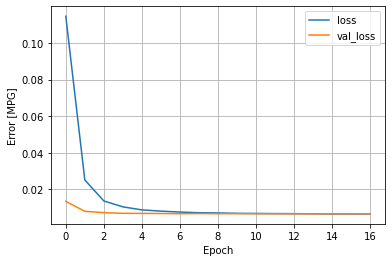

In [45]:
plot_loss(history)

In [35]:
df_match

,subj_idx,A,rt,power,trial_no,noise,anes,drug,normN_trial_no,normN_rt,normN_power,bin_trial,A_noise
0,8,0,507.6,-0.022572,2,1,0,0,0.002677,0.462464,0.158858,0,3.0
1,8,0,721.3,0.014286,13,1,0,0,0.017403,0.657161,0.198617,0,3.0
2,8,0,509.1,0.041667,14,1,0,0,0.018742,0.463830,0.228153,0,3.0
3,8,0,547.6,0.067568,15,1,0,0,0.020080,0.498907,0.256093,0,3.0
4,8,0,726.8,0.098039,17,0,0,0,0.022758,0.662172,0.288962,0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
10487,2229,0,642.4,0.483900,388,1,0,1,0.984772,0.589899,0.878177,19,3.0
10488,2229,1,684.1,0.261880,389,1,0,1,0.987310,0.628191,0.518602,19,4.0
10489,2229,0,617.6,0.488610,391,1,0,1,0.992386,0.567126,0.885805,19,3.0
10490,2229,1,652.0,0.264350,392,1,0,1,0.994924,0.598714,0.522603,19,4.0


In [36]:
#creating dataset for plotting
%matplotlib inline

import matplotlib

def plot_clear_vs_noisy(X_testQ, ttle, nparray):
    X_test_A1_clear = X_testQ[X_testQ[:, nparray[0]] == 1]
    X_test_A2_clear = X_testQ[X_testQ[:, nparray[1]] == 1]
    X_test_A3_clear = X_testQ[X_testQ[:, nparray[2]] == 1]

    X_test_A1_noisy = X_testQ[X_testQ[:, nparray[3]] == 1]
    X_test_A2_noisy = X_testQ[X_testQ[:, nparray[4]] == 1]
    X_test_A3_noisy = X_testQ[X_testQ[:, nparray[5]] == 1]

    y_pred_A1_clear = model.predict(X_test_A1_clear)
    y_pred_A2_clear = model.predict(X_test_A2_clear)
    y_pred_A3_clear = model.predict(X_test_A3_clear)

    y_pred_A1_noisy = model.predict(X_test_A1_noisy)
    y_pred_A2_noisy = model.predict(X_test_A2_noisy)
    y_pred_A3_noisy = model.predict(X_test_A3_noisy)

    fig, ax = plt.subplots(1, 3, sharex = True, sharey = True)
    ax[0].scatter(X_test_A1_clear[:, 0],y_pred_A1_clear, c = 'r')
    ax[0].scatter(X_test_A1_noisy[:, 0],y_pred_A1_noisy, c = 'r', alpha = 0.03)
    ax[1].scatter(X_test_A2_clear[:, 0],y_pred_A2_clear, c ='g')
    ax[1].scatter(X_test_A2_noisy[:, 0],y_pred_A2_noisy, c ='g', alpha =0.03)
    ax[2].scatter(X_test_A3_clear[:, 0],y_pred_A3_clear, c ='b')
    ax[2].scatter(X_test_A3_noisy[:, 0],y_pred_A3_noisy, c ='b', alpha = 0.03)
    ax[0].set_xlabel('trial_no')
    ax[1].set_xlabel('trial_no')
    ax[2].set_xlabel('trial_no')
    ax[0].set_ylabel('rt')
    ax[1].set_title(ttle)
    #fig, ax = plt.subplots(1, 2, sharex = True, sharey = True)
    #ax[0].scatter(X_test_A1_clear[:, 7],1/y_pred_A1_clear, c = 'r', alpha = 0.03)
    #ax[1].scatter(X_test_A1_noisy[:, 7],1/y_pred_A1_noisy, c = 'magenta', alpha = 0.07)
    #ax[0].scatter(X_test_A2_clear[:, 7],1/y_pred_A2_clear, c ='g', alpha = 0.03)
    #ax[1].scatter(X_test_A2_noisy[:, 7],1/y_pred_A2_noisy, c ='cyan', alpha =0.07)
    #ax[0].scatter(X_test_A3_clear[:, 7],1/y_pred_A3_clear, c ='b', alpha = 0.03)
    #ax[1].scatter(X_test_A3_noisy[:, 7],1/y_pred_A3_noisy, c ='pink', alpha = 0.07)
    #ax[0].set_xlabel('trial_no')
    #ax[0].set_ylabel('speed')

    #fig, ax = plt.subplots(1, 3, sharex = True, sharey = True)
    #ax[0].scatter(X_test_A1_clear[:, 7],1/y_pred_A1_clear, c = 'r', alpha = 0.03)
    #ax[0].scatter(X_test_A1_noisy[:, 7],1/y_pred_A1_noisy, c = 'magenta', alpha = 0.07)
    #ax[1].scatter(X_test_A2_clear[:, 7],1/y_pred_A2_clear, c ='g', alpha = 0.03)
    #ax[1].scatter(X_test_A2_noisy[:, 7],1/y_pred_A2_noisy, c ='cyan', alpha =0.07)
    #ax[2].scatter(X_test_A3_clear[:, 7],1/y_pred_A3_clear, c ='b', alpha = 0.03)
    #ax[2].scatter(X_test_A3_noisy[:, 7],1/y_pred_A3_noisy, c ='pink', alpha = 0.07)
    #ax[0].set_xlabel('trial_no')
    #ax[0].set_ylabel('speed')

    #fig, ax = plt.subplots(1, 3, sharex = True, sharey = True)
    #ax[0].scatter(X_test_A1_clear[:, 7],X_test_A1_clear[:, 0], c = 'r', alpha = 0.03)
    #ax[0].scatter(X_test_A1_noisy[:, 7],X_test_A1_noisy[:, 0], c = 'magenta', alpha = 0.07)
    #ax[1].scatter(X_test_A2_clear[:, 7],X_test_A2_clear[:, 0], c ='g', alpha = 0.03)
    #ax[1].scatter(X_test_A2_noisy[:, 7],X_test_A2_noisy[:, 0], c ='cyan', alpha =0.07)
    #ax[2].scatter(X_test_A3_clear[:, 7],X_test_A3_clear[:, 0], c ='b', alpha = 0.03)
    #ax[2].scatter(X_test_A3_noisy[:, 7],X_test_A3_noisy[:, 0], c ='pink', alpha = 0.07)
    #ax[0].set_xlabel('trial_no')
    #ax[0].set_ylabel('power')

    y_noisy = np.concatenate((y_pred_A1_noisy, y_pred_A2_noisy, y_pred_A3_noisy) )
    y_clear = np.concatenate((y_pred_A1_clear, y_pred_A2_clear, y_pred_A3_clear) )


    fig, br = plt.subplots(1, 2)
    br[0].bar(np.arange(3), [np.var(y_pred_A1_noisy) - np.var(y_pred_A1_clear),
                        np.var(y_pred_A2_noisy) - np.var(y_pred_A2_clear),
                         np.var(y_pred_A3_noisy) - np.var(y_pred_A3_clear)],
          color=['red', 'green',  'blue'])
    br[0].set_xlabel('std rt noisy - clear')
    br[1].bar(np.arange(3), [np.mean(y_pred_A1_noisy) - np.mean(y_pred_A1_clear),
                        np.mean(y_pred_A2_noisy) - np.mean(y_pred_A2_clear),
                         np.mean(y_pred_A3_noisy) - np.mean(y_pred_A3_clear)],
          color=['red', 'green',  'blue'])
    br[1].set_xlabel('mean rt noisy - clear')
    #br[2].bar(np.arange(2), [np.var(y_clear), np.var(y_noisy)], color = ['pink', 'cyan'])
    #br[2].set_xlabel('separation between lines')
    fig, ax = plt.subplots(1, 2, sharey = True, sharex = True)
    ax[0].scatter(X_test_A1_clear[:, 0], y_pred_A1_clear, c = 'r')
    ax[0].scatter(X_test_A2_clear[:, 0],y_pred_A2_clear, c ='g')
    ax[0].scatter(X_test_A3_clear[:, 0],y_pred_A3_clear,  c ='b')

    ax[1].scatter(X_test_A1_noisy[:, 0],y_pred_A1_noisy,  c = 'r', alpha = 0.3)
    ax[1].scatter(X_test_A2_noisy[:, 0],y_pred_A2_noisy,  c ='g', alpha =0.3)
    ax[1].scatter(X_test_A3_noisy[:, 0],y_pred_A3_noisy,  c ='b', alpha = 0.3)
    ax[0].set_xlabel('trial no')
    ax[1].set_xlabel('trial no')
    ax[0].set_ylabel('rt')
    ax[1].legend(['highly predictive', 'moderately predictive', 'not predictive'], loc='upper center', bbox_to_anchor=(0, -.2),
          fancybox=True, shadow=True, ncol=5)



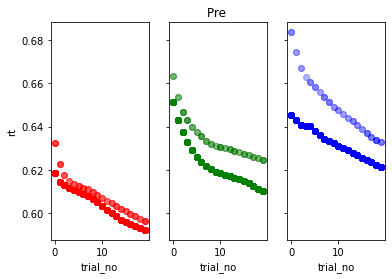

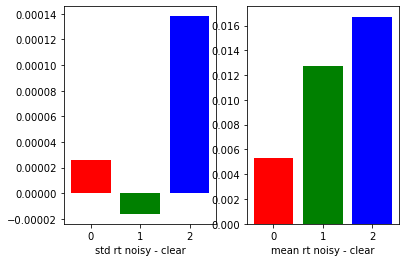

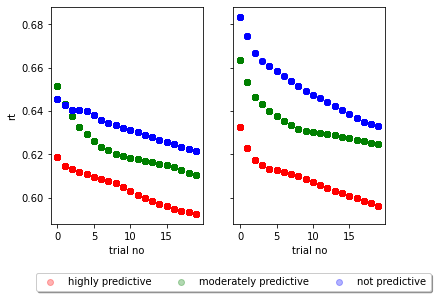

In [46]:
#plot_clear_vs_noisy(X_test, 'Pre test')
#plot_clear_vs_noisy(X_train, 'Pre train')

plot_clear_vs_noisy(X_test, 'Pre ', np.array([1, 2, 3, 4, 5, 6]))
#plot_clear_vs_noisy(X_test, 'under Dex', np.array([7, 8, 9, 10, 11, 12]))
#plot_clear_vs_noisy(X_test, 'under ketamine', np.array([13, 14, 15, 16, 17, 18]))

#plot_clear_vs_noisy(X_train, 'Pre train')

#plot_clear_vs_noisy(X_test[X_test[:, 7] == 1], 'Pre')
#plot_clear_vs_noisy(X_test[X_test[:, 8] == 1], 'Dex')
#plot_clear_vs_noisy(X_test[X_test[:, 9] == 1], 'ketamine')
